# Compute the pKa's from a set of single-pH simulations

One way to use the CpHMD method to obtain the pKa's of residues in a protein is to choose a set of pH values over the pH-range of interest and run separate simulations at each pH. You can then extract the fraction of the time that each residue was deprotonated at each pH and fit these values the Henderson-Hasselbalch equation.

Alternatively, one can use pH replica-exchange to accelerate the calculations. Like in the single-pH simulations, multiple simulations are run at different pH's, but in the replica-exchange methods these simulations periodically attempt to swap pH states, potentially allowing the system to escape local free energy minima.

The notebook cphmdanalysis_replica.ipynb provides an example of how to analyze the results from a replica-exchange run in Amber.

Although the importance-sampling provided by replica exchange makes that method more attractive than single-pH calculations in most circumstances, single-pH calculations can be useful in resource-constrained environments. For example, in replica exchange on GPUs in Amber, one GPU is required for each replica. Obtaining several connected GPUs to run such a calculation may not always be possible.

## Import library

First, import the library to give access to the cphmd commands plus the plotting libraries so that we can view our data.

In [12]:
from cphmd_tools import cphmdanalysis
import matplotlib
import matplotlib.pyplot as plt

## Define constants

Here I define a list of pH's at which the job was run.

I define a list of strings as well as floats so that I can more easily specify the file paths later, but in general this is not necessary.

This example was taken from a project where we were interested in the pKa of a particular Cys residue, whose experimental pKa was 5.3. I therefore ran one simulation at that pKa and other simulations at intervals of 1 pH unit.

In most circumstances, you won't know what the pKa of your residue of interest is or you will be interested in the pKa's of multiple residues. In those cases, I would recommend using simpler pH values, such as whole units or half units.

Setting the spacing between pH values can be very important. The titration curves from single-pH simulations can be noisy, and sometimes you will need to add additional windows to obtain a well-fit curve.

In [2]:
single_ph_strings = ['3.30', '4.30', '5.30', '6.30', '7.30', '8.30', '9.30']
single_phs = [float(ph) for ph in single_ph_strings]

## Read lambda files

The first step is to read in all of the lambda files generated from the simulations. In example_data/single_ph_lambdas we have the lambda files generated from a set of single-pH simulations. This command creates a list of lambda_file objects, which each store all of the information from the lambda files so it can easily be accessed through the members of the objects. These objects are then used by the other functions to calculate the pKa's.

For a detailed definition of the lambda_file objects and a list of all members, check the detailed documentation in cphmdanalysis.py.

In [3]:
print(cphmdanalysis.henderson_hasselbalch_for_fitting.__doc__)

None


In [4]:
lambda_files = [cphmdanalysis.lambda_file('example_data/single_ph_lambdas/1eh6_{}.lambda'.format(ph))
                for ph in single_ph_strings]

## Compute S values

Now, we need to compute the unprotonated fractions so that we can fit to the Henderson-Hasselbalch equation. This is done with the function compute_s_values.

In [5]:
for lambda_file in lambda_files:
    lambda_file.compute_s_values()

## Compute pKa's

Now, compute the pKa's of the titratable residues. compute_pkas returns a list of lists containing one list for each titratable residue that in turn contains in order the Hill coefficient, the fitting error in the Hill coefficient, the pKa, and the fitting error in pKa.

Because the Henderson-Hasselbalch equation is nonlinear, we have to make initial guesses for the Hill coefficient and pKa. The algorithm here guesses that the Hill coefficient is 1. It takes as the initial guess of the pKa the pH value the unprotonated fraction is closest to 0.5, unless none of the unprotonated fractions are between 0.1 and 0.9. If there is no appropriate pH to pick as an initial guess or if the fitting function fails to converge, the algorithm will return math.nan for the pKa data for that residue.

This function does not throw errors when the fitting fails because often there will be residues that do not titrate in the pH range, and if these residues are not ones you are interested in it is usually not a problem. Later in the notebook, I will show how to look more closely at these cases.

In [6]:
pka_data = cphmdanalysis.compute_pkas(single_phs, lambda_files)

## Print pKa data

Now, print the pKa estimates and Hill values. Note that the titrreses directory in the lambda_file objects contains the residue indices of the titratable residues. This means, if, for example, we want to know what the pKa of a particular residue is, we can pull it out of the pKa data using this array, as is shown in the next cell.

In [7]:
print('Residue Hill pKa')
for i, resid in enumerate(lambda_files[0].titrreses):
    print('{} {:.2f} {:.1f}'.format(resid, pka_data[i][0], pka_data[i][2]))

Residue Hill pKa
2 2.08 6.6
3 0.72 3.7
5 nan nan
10 0.69 3.4
15 nan nan
17 0.66 4.0
21 0.38 5.6
22 0.57 3.9
26 0.67 6.3
27 0.40 2.6
29 nan nan
33 nan nan
39 0.62 3.6
42 0.68 4.5
54 0.60 4.1
59 nan nan
68 0.77 7.4
71 0.62 3.8
74 0.84 4.7
75 0.82 4.4
82 0.75 6.3
83 1.65 3.2
89 0.86 3.7
98 1.00 9.9
101 nan nan
104 nan nan
107 0.87 3.5
122 0.96 10.2
142 0.27 5.9
143 0.41 3.7
147 nan nan
162 0.52 10.9
163 0.86 4.4
168 0.95 7.4
169 0.63 3.8
171 0.78 6.3


Say that we are interested specifically in the pKa of residue 142, which was the Cys residue we were interested in. We can use the titrreses array in the lambda_file object to pull it out of the pka_data object:

In [11]:
residue = 142
print('pKa of residue 142 = {:.1f}'.format(pka_data[lambda_files[0].titrreses.index(residue)][2]))

pKa of residue 142 = 5.9


We can check to see why a residue did not return a pKa by looking directly at the unprotonated fractions:

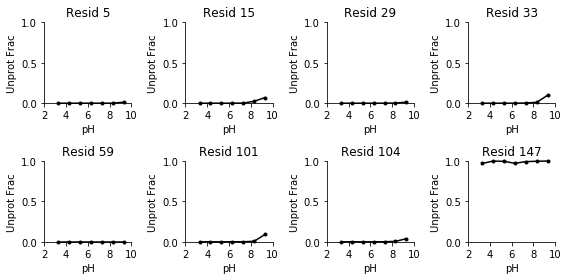

In [26]:
plt.close('all')
figrows = 2
figcols = 4
width = 8
height = 4
ylims = [0, 1]
yticks = [0, 0.5, 1]
xlims = [2, 10]
xticks = [2, 4, 6, 8, 10]
xlabel = 'pH'
ylabel = 'Unprot Frac'

#List residues that have pKa=nan
nan_residue_list = [5, 15, 29, 33, 59, 101, 104, 147]

fig, axes = plt.subplots(ncols = figcols, nrows = figrows, figsize = (width, height))
flat_axes = axes.flatten()
for i, axis in enumerate(flat_axes):
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_ylim(ylims)
    axis.set_yticks(yticks)
    axis.set_xlim(xlims)
    axis.set_xticks(xticks)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title('Resid {}'.format(nan_residue_list[i]))
    #Get S-values (unprotonated fractions) for residue i
    s_values = [lambda_file.s[lambda_file.titrreses.index(nan_residue_list[i])]
               for lambda_file in lambda_files]
    axis.plot(single_phs, s_values, 'k-', marker = '.', clip_on = False)
fig.tight_layout()
plt.show()

Apparently, residues 5, 15, 29, 33, 59, 101, and 104 have pKa's above our pH range (>9.3). Conversely, residue 147 appears to have a pKa below our pH range (<3.3)